
# ITFFC — Task 2: Conditional GAN (ACGAN) + Synthetic Augmentation

This notebook trains a **conditional GAN (ACGAN)** on the **medical** processed images only and generates synthetic data to **balance class imbalance**.

- **Input root (processed):** `C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical`
- It automatically discovers every `*_processed` leaf folder and treats each as a class.
- Trains on GPU (CUDA)  (my RTX 3060), with **AMP mixed precision** for speed.
- After training (**100 epochs** by default), it generates samples **per class** to reach the count of the largest class.
- Synthetic images are saved under:  
  `...\Dataset\medical_synthetic\<class>\*.png`

> Model: **ACGAN** (Discriminator outputs real/fake + class logits; Generator conditioned on class labels).  
> Image size default: **256×256**, channels: **3**, latent dim: **128**.


In [1]:

# =======================================
# Configuration
# =======================================
from pathlib import Path

DATASET_MEDICAL_ROOT = r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical"

image_size   = 256
channels     = 3
latent_dim   = 128
batch_size   = 32
num_epochs   = 100
lr_G         = 2e-4
lr_D         = 2e-4
beta1, beta2 = 0.5, 0.999
num_workers  = 4

samples_per_grid = 16
save_preview_every = 5
balance_to_largest = True

OUTPUT_ROOT = Path(DATASET_MEDICAL_ROOT).parent / "medical_synthetic"
CHECKPOINTS = Path(DATASET_MEDICAL_ROOT).parent / "gan_ckpts"
PREVIEWS    = Path(DATASET_MEDICAL_ROOT).parent / "gan_previews"

print("Synthetic out:", OUTPUT_ROOT)
print("Checkpoints  :", CHECKPOINTS)
print("Previews     :", PREVIEWS)


Synthetic out: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic
Checkpoints  : C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_ckpts
Previews     : C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_previews



### Optional: Install libraries (run only if needed)
If your environment is missing packages, run the cell below.


Looking in indexes: https://download.pytorch.org/whl/cu124


In [3]:

# =======================================
# Imports
# =======================================

import os, sys, math, json, random, time
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Device: cuda
Torch: 2.6.0+cu124
CUDA available: True


In [4]:
# =======================================
# Data utilities (adapted for medcial/alzheimer + covid19)
# =======================================
from pathlib import Path
from collections import Counter


DATASET_ALZHEIMER_ROOT = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer")
DATASET_COVID19_ROOT   = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\covid19")

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def find_leaf_processed_dirs(root: Path):
    """
    Returns all folders containing processed images directly.
    Works for both: 
      <Class>_processed/*.png
    or  <Class>/images_processed/*.png
    """
    root = Path(root)
    out = set()

    for p in root.rglob("*"):
        if not p.is_dir():
            continue
        name = p.name.lower()

        # Case 1: class_processed
        if name.endswith("_processed"):
            files = list(p.glob("*"))
            has_imgs = any(f.is_file() and f.suffix.lower() in IMG_EXTS for f in files)
            has_subdirs = any(f.is_dir() for f in files)
            if has_imgs and not has_subdirs:
                out.add(p)
                continue
            # Optional nested case
            img_sub = p / "images_processed"
            if img_sub.is_dir() and any(f.is_file() and f.suffix.lower() in IMG_EXTS for f in img_sub.iterdir()):
                out.add(img_sub)
                continue

        # Case 2: class/images_processed
        if name == "images_processed":
            if any(f.is_file() and f.suffix.lower() in IMG_EXTS for f in p.iterdir()):
                out.add(p)

    return sorted(out)

def class_name_from_processed_dir(d: Path):
    """
    Extract class name from processed dir path.
    """
    if d.name.lower() == "images_processed":
        return d.parent.name
    if d.name.endswith("_processed"):
        return d.name[:-10]
    return d.name

# === Combine both Alzheimer and Covid19 roots ===
processed_dirs = find_leaf_processed_dirs(DATASET_ALZHEIMER_ROOT) + find_leaf_processed_dirs(DATASET_COVID19_ROOT)
assert len(processed_dirs) > 0, "No *_processed folders found under medcial/alzheimer or medcial/covid19."

class_names = [class_name_from_processed_dir(d) for d in processed_dirs]
num_classes = len(class_names)

print(f"Found {num_classes} classes:")
for d, cname in zip(processed_dirs, class_names):
    print(" -", cname, "from", d)

class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

# =======================================
# Dataset
# =======================================
class ProcessedImagesDataset(Dataset):
    def __init__(self, processed_dirs, class_to_idx, image_size=256, channels=3, augment=True):
        self.samples = []
        self.class_to_idx = class_to_idx
        self.channels = channels

        for d in processed_dirs:
            cname = class_name_from_processed_dir(d)
            y = class_to_idx[cname]
            for imgp in d.glob("*"):
                if imgp.is_file() and imgp.suffix.lower() in IMG_EXTS:
                    self.samples.append((imgp, y))

        aug_list = []
        if augment:
            aug_list += [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=5),
            ]
        aug_list += [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*channels, [0.5]*channels),
        ]
        self.transform = transforms.Compose(aug_list)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        return x, y

dataset = ProcessedImagesDataset(processed_dirs, class_to_idx, image_size=image_size, channels=channels, augment=True)
print("Dataset size:", len(dataset))

counts = Counter([y for _, y in dataset.samples])
for k, v in counts.items():
    print(f"{idx_to_class[k]}: {v}")

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


Found 6 classes:
 - MildDemented from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\MildDemented_processed
 - ModerateDemented from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\ModerateDemented_processed
 - NonDemented from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\NonDemented_processed
 - VeryMildDemented from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\VeryMildDemented_processed
 - Lung_Opacity from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\covid19\Lung_Opacity_processed
 - normal from C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\covid19\normal_processed
Dataset size: 22604
MildDemented: 896
ModerateDemented: 64
NonDemented: 3200
VeryMildDemented: 2240
Lung_Opacity: 6012
normal: 10192


Total images: 22604
normal                   10192  (45.09 %)
Lung_Opacity              6012  (26.60 %)
NonDemented               3200  (14.16 %)
VeryMildDemented          2240  ( 9.91 %)
MildDemented               896  ( 3.96 %)
ModerateDemented            64  ( 0.28 %)
Saved plot to: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_previews\class_distribution_before_gan.png


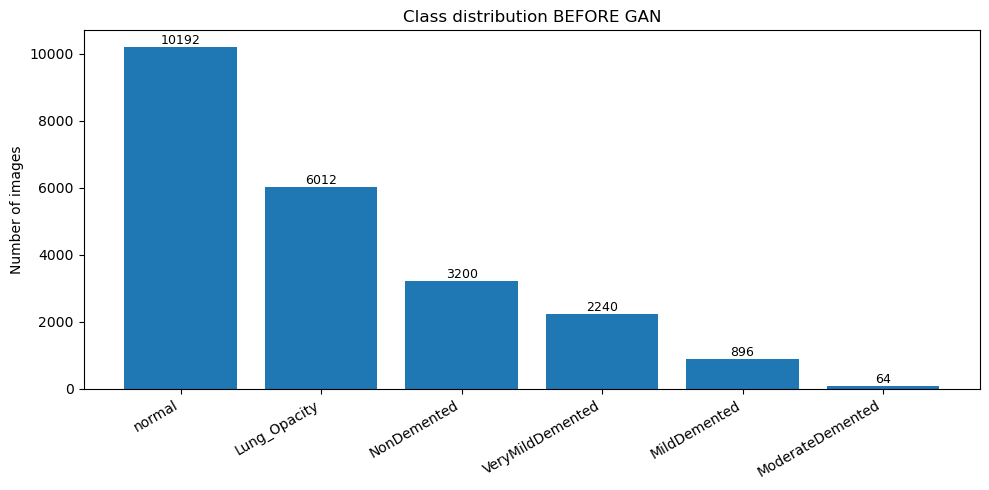

In [5]:
# =======================================
# Class distribution (before GAN) — plot
# =======================================
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count images per class from the loaded dataset
counts = Counter([y for _, y in dataset.samples])

# Build arrays ordered by descending count
cls_idx_sorted = sorted(counts.keys(), key=lambda k: counts[k], reverse=True)
cls_names = [idx_to_class[k] for k in cls_idx_sorted]
cls_values = np.array([counts[k] for k in cls_idx_sorted], dtype=int)

total = cls_values.sum()
proportions = (cls_values / total) * 100.0

print("Total images:", total)
for name, n, p in zip(cls_names, cls_values, proportions):
    print(f"{name:<22} {n:>7}  ({p:5.2f} %)")

# --- Bar chart ---
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(cls_names)), cls_values)
plt.title("Class distribution BEFORE GAN")
plt.ylabel("Number of images")
plt.xticks(range(len(cls_names)), cls_names, rotation=30, ha="right")

# Annotate counts above bars
for rect, val in zip(bars, cls_values):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
             f"{val}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

# Save the figure next to other previews if available
try:
    (PREVIEWS).mkdir(parents=True, exist_ok=True)
    out_fig = PREVIEWS / "class_distribution_before_gan.png"
    plt.savefig(out_fig, dpi=150)
    print("Saved plot to:", out_fig)
except Exception as e:
    print("Could not save plot (showing inline instead):", e)

plt.show()


In [6]:

# =======================================
# ACGAN models
# =======================================
class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True)
        )
    def forward(self, x): return self.net(x)

class DisBlock(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super().__init__()
        layers = [nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False)]
        if bn:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels=3, base=64):
        super().__init__()
        cond_dim = num_classes
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, base*16*4*4),
            nn.ReLU(True)
        )
        self.net = nn.Sequential(
            GenBlock(base*16, base*8),  # 8x8
            GenBlock(base*8, base*4),   # 16x16
            GenBlock(base*4, base*2),   # 32x32
            GenBlock(base*2, base),     # 64x64
            GenBlock(base, base//2),    # 128x128
            nn.ConvTranspose2d(base//2, img_channels, 4, 2, 1, bias=False),  # 256x256
            nn.Tanh()
        )
        self.num_classes = num_classes

    def forward(self, z, y):
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        zc = torch.cat([z, y_onehot], dim=1)
        x = self.fc(zc).view(z.size(0), -1, 4, 4)
        img = self.net(x)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels=3, base=64):
        super().__init__()
        self.feature = nn.Sequential(
            DisBlock(img_channels, base, bn=False),
            DisBlock(base, base*2),
            DisBlock(base*2, base*4),
            DisBlock(base*4, base*8),
            DisBlock(base*8, base*16),
            nn.Conv2d(base*16, base*16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.adv_head = nn.Conv2d(base*16, 1, 4, 1, 0, bias=False)
        self.cls_head = nn.Conv2d(base*16, num_classes, 4, 1, 0, bias=False)

    def forward(self, x):
        f = self.feature(x)
        adv = self.adv_head(f).view(x.size(0), 1)
        cls = self.cls_head(f).view(x.size(0), -1)
        return adv, cls
print("preparation")

preparation


In [7]:
# --- DIAGNOSTICS ---
import torch, os, sys
from pathlib import Path

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("torch.version.cuda:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Check your config values exist
try:
    print("image_size:", image_size, "batch_size:", batch_size, "num_workers:", num_workers)
except NameError as e:
    print("Config variable missing:", e)

# If CUDA is available but not used, force device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


num_workers = 0

# Rebuild loader with safe settings
pin = (device.type == "cuda")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin)

# Try to get one batch to confirm nothing hangs
from time import perf_counter
t0 = perf_counter()
xb, yb = next(iter(loader))
t1 = perf_counter()
print(f"One batch OK: shape={tuple(xb.shape)}, labels[0:5]={yb[:5].tolist()}, load_time={t1-t0:.3f}s")


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Torch: 2.6.0+cu124
CUDA available: True
torch.version.cuda: 12.4
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
image_size: 256 batch_size: 32 num_workers: 4
Using device: cuda
One batch OK: shape=(32, 3, 256, 256), labels[0:5]=[3, 5, 5, 2, 5], load_time=0.381s


In [8]:
# =======================================
# Training loop with AMP 
# =======================================
import math, os
from tqdm.auto import tqdm
import torch.nn as nn
import torch

torch.backends.cudnn.benchmark = True


G = Generator(latent_dim, num_classes, img_channels=channels).to(device)
D = Discriminator(num_classes, img_channels=channels).to(device)

optG = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
optD = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))

adv_loss = nn.BCEWithLogitsLoss().to(device)
cls_loss = nn.CrossEntropyLoss().to(device)

# New AMP API
scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))

# Ensure output dirs
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
PREVIEWS.mkdir(parents=True, exist_ok=True)

# Fixed noise for previews
fixed_z = torch.randn(samples_per_grid, latent_dim, device=device)
fixed_labels = torch.tensor([i % num_classes for i in range(samples_per_grid)], device=device)

def preview(epoch):
    G.eval()
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
        imgs = G(fixed_z, fixed_labels)
        imgs = (imgs + 1) * 0.5
        grid = make_grid(imgs.clamp(0,1), nrow=int(math.sqrt(samples_per_grid)))
        save_image(grid, PREVIEWS / f"epoch_{epoch:04d}.png")
    G.train()

print("Starting the training...", flush=True)
preview(0)  # save an initial preview before any training

for epoch in range(1, num_epochs+1):
    G.train(); D.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)
    for batch_idx, (real, y) in enumerate(pbar):
        real = real.to(device, non_blocking=True)
        y    = y.to(device, non_blocking=True)
        bsz  = real.size(0)

        # ---- Train D ----
        z = torch.randn(bsz, latent_dim, device=device)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            fake = G(z, y).detach()
            adv_real, cls_real = D(real)
            d_real = adv_loss(adv_real, torch.ones_like(adv_real))
            c_real = cls_loss(cls_real, y)

            adv_fake, _ = D(fake)
            d_fake = adv_loss(adv_fake, torch.zeros_like(adv_fake))

            d_loss = d_real + d_fake + c_real

        optD.zero_grad(set_to_none=True)
        scaler.scale(d_loss).backward()
        scaler.step(optD)

        # ---- Train G ----
        z = torch.randn(bsz, latent_dim, device=device)
        y_fake = torch.randint(0, num_classes, (bsz,), device=device)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            gen = G(z, y_fake)
            adv_gen, cls_gen = D(gen)
            g_adv = adv_loss(adv_gen, torch.ones_like(adv_gen))
            g_cls = cls_loss(cls_gen, y_fake)
            g_loss = g_adv + g_cls

        optG.zero_grad(set_to_none=True)
        scaler.scale(g_loss).backward()
        scaler.step(optG)
        scaler.update()

        if device.type == 'cuda':
            torch.cuda.synchronize()  # make timing/progress accurate

        pbar.set_postfix(d=float(d_loss.item()), g=float(g_loss.item()))

    # Save preview and checkpoint EVERY epoch (more frequent)
    preview(epoch)
    torch.save({
        "G": G.state_dict(),
        "D": D.state_dict(),
        "epoch": epoch,
        "class_to_idx": class_to_idx,
        "config": {
            "latent_dim": latent_dim, "image_size": image_size,
            "channels": channels, "num_classes": num_classes
        }
    }, CHECKPOINTS / f"acgan_epoch_{epoch:04d}.pt")

print("Training complete.", flush=True)
preview(num_epochs)


Starting the training...


Epoch 1/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/707 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/707 [00:00<?, ?it/s]

Training complete.


In [9]:

# =======================================
# Synthetic generation to balance classes
# =======================================
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

from collections import Counter
class_counts = Counter([y for _, y in dataset.samples])
max_count = max(class_counts.values())

def generate_for_class(cls_idx, n_images, batch=64):
    out_dir = OUTPUT_ROOT / idx_to_class[cls_idx]
    out_dir.mkdir(parents=True, exist_ok=True)
    G.eval()
    saved = 0
    with torch.no_grad():
        while saved < n_images:
            cur = min(batch, n_images - saved)
            z = torch.randn(cur, latent_dim, device=device)
            y = torch.full((cur,), cls_idx, device=device, dtype=torch.long)
            imgs = G(z, y)
            imgs = (imgs + 1) * 0.5
            for i in range(cur):
                save_image(imgs[i].clamp(0,1), out_dir / f"gen_{saved+i:06d}.png")
            saved += cur
    return saved

gen_plan = {}
for k,v in class_counts.items():
    target = max_count if balance_to_largest else v
    need = max(0, target - v)
    gen_plan[k] = need

print("Generation plan (#images to create per class):")
for k,need in gen_plan.items():
    print(f" - {idx_to_class[k]}: need {need}")

total_to_gen = sum(gen_plan.values())
print("Total to generate:", total_to_gen)

if total_to_gen > 0:
    for k,need in gen_plan.items():
        if need > 0:
            made = generate_for_class(k, need, batch=64)
            print(f"Generated {made} images for class {idx_to_class[k]}")
else:
    print("Dataset already balanced by max class count; no generation needed.")

print("Synthetic images saved under:", OUTPUT_ROOT)


Generation plan (#images to create per class):
 - MildDemented: need 9296
 - ModerateDemented: need 10128
 - NonDemented: need 6992
 - VeryMildDemented: need 7952
 - Lung_Opacity: need 4180
 - normal: need 0
Total to generate: 38548
Generated 9296 images for class MildDemented
Generated 10128 images for class ModerateDemented
Generated 6992 images for class NonDemented
Generated 7952 images for class VeryMildDemented
Generated 4180 images for class Lung_Opacity
Synthetic images saved under: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic


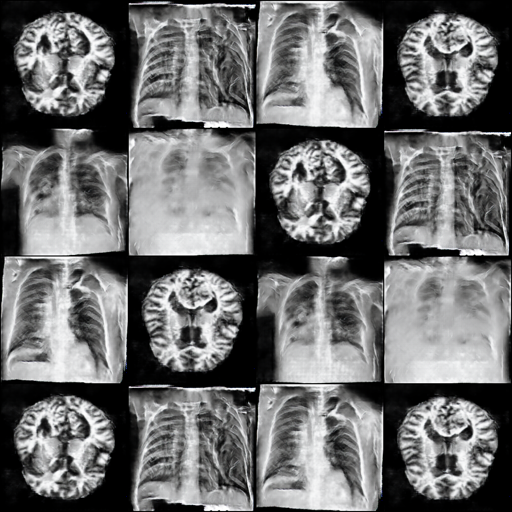

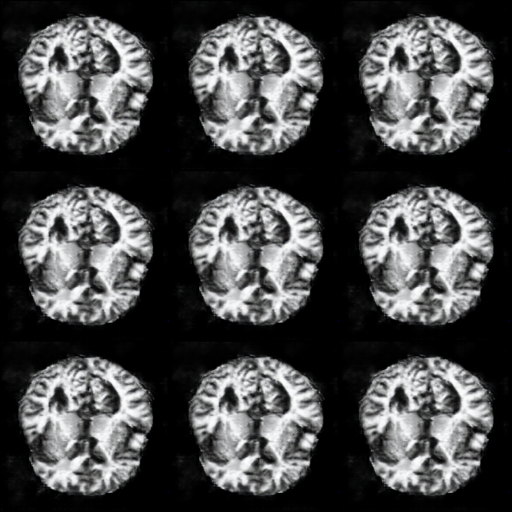

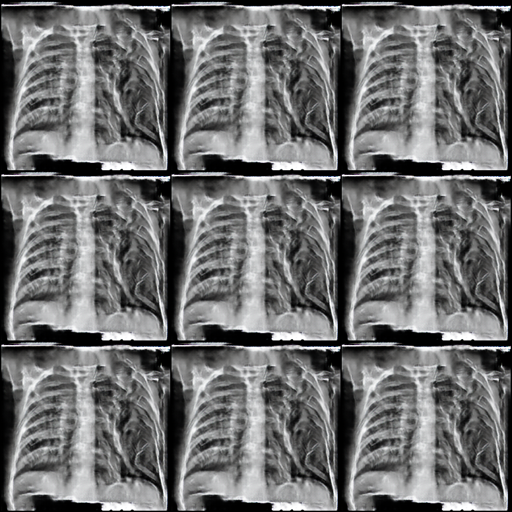

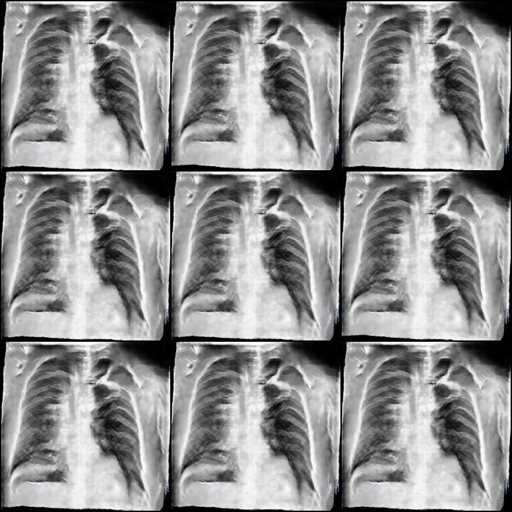

In [10]:

# =======================================
# Quick visualization
# =======================================
from IPython.display import display
preview_imgs = sorted(PREVIEWS.glob("*.png"))
if preview_imgs:
    display(Image.open(preview_imgs[-1]).resize((512,512)))
else:
    print("No preview images found yet.")

for c in list(idx_to_class.values())[:3]:
    sample_dir = OUTPUT_ROOT / c
    if sample_dir.exists():
        samples = list(sample_dir.glob("*.png"))[:9]
        if samples:
            grid = []
            for p in samples:
                grid.append(transforms.ToTensor()(Image.open(p).convert("RGB")))
            grid = torch.stack(grid, dim=0)
            save_image(make_grid(grid, nrow=3), PREVIEWS / f"synthetic_{c}.png")
            display(Image.open(PREVIEWS / f"synthetic_{c}.png").resize((512,512)))


=== Class distribution AFTER GAN ===
MildDemented           real=   896  synth=  9296  total=  10192
ModerateDemented       real=    64  synth= 10128  total=  10192
NonDemented            real=  3200  synth=  6992  total=  10192
VeryMildDemented       real=  2240  synth=  7952  total=  10192
Lung_Opacity           real=  6012  synth=  4180  total=  10192
normal                 real= 10192  synth=     0  total=  10192

TOTALS -> real=22604  synth=38548  combined=61152
Saved plot to: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_previews\class_distribution_after_gan.png


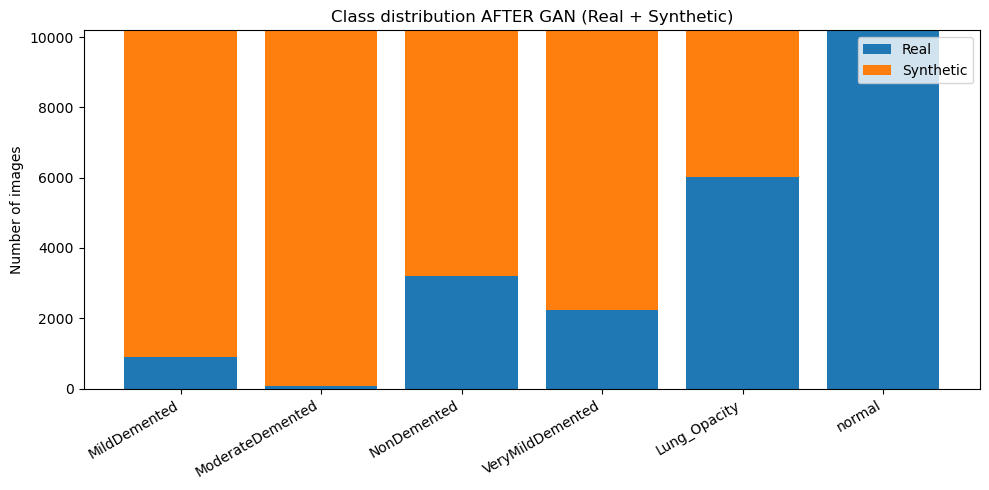

Saved CSV to: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_previews\class_distribution_after_gan.csv


In [11]:
# =======================================
# Class distribution AFTER GAN (real + synthetic)
# =======================================
from collections import Counter
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# 1) Real counts (already in `dataset.samples`)
real_counts = Counter([y for _, y in dataset.samples])

# 2) Synthetic counts (scan OUTPUT_ROOT/<class>/*.png)
def count_images_in_dir(d: Path):
    if not d.exists(): 
        return 0
    return sum(1 for f in d.iterdir() if f.is_file() and f.suffix.lower() in IMG_EXTS)

synthetic_counts = {}
for idx, cname in idx_to_class.items():
    cdir = OUTPUT_ROOT / cname
    synthetic_counts[idx] = count_images_in_dir(cdir)

# 3) Build arrays (sorted by TOTAL desc)
cls_idx = list(idx_to_class.keys())
totals = {i: real_counts.get(i,0) + synthetic_counts.get(i,0) for i in cls_idx}
cls_idx_sorted = sorted(cls_idx, key=lambda k: totals[k], reverse=True)

names   = [idx_to_class[i] for i in cls_idx_sorted]
real    = np.array([real_counts.get(i,0) for i in cls_idx_sorted], dtype=int)
synthet = np.array([synthetic_counts.get(i,0) for i in cls_idx_sorted], dtype=int)
total   = real + synthet

# 4) Print summary
print("=== Class distribution AFTER GAN ===")
grand_total_real    = int(real.sum())
grand_total_synth   = int(synthet.sum())
grand_total_combined= int(total.sum())
for n, r, s, t in zip(names, real, synthet, total):
    print(f"{n:<22} real={r:>6}  synth={s:>6}  total={t:>7}")
print(f"\nTOTALS -> real={grand_total_real}  synth={grand_total_synth}  combined={grand_total_combined}")

# 5) Plot (stacked bars)
x = np.arange(len(names))
plt.figure(figsize=(10,5))
bar1 = plt.bar(x, real, label="Real")
bar2 = plt.bar(x, synthet, bottom=real, label="Synthetic")
plt.xticks(x, names, rotation=30, ha="right")
plt.ylabel("Number of images")
plt.title("Class distribution AFTER GAN (Real + Synthetic)")
plt.legend()
plt.tight_layout()

# Save the figure next to other previews
PREVIEWS.mkdir(parents=True, exist_ok=True)
out_fig = PREVIEWS / "class_distribution_after_gan.png"
plt.savefig(out_fig, dpi=150)
print("Saved plot to:", out_fig)

plt.show()

# 6) Optional: save CSV summary
import csv
csv_path = PREVIEWS / "class_distribution_after_gan.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["class", "real", "synthetic", "total"])
    for n, r, s, t in zip(names, real, synthet, total):
        w.writerow([n, r, s, t])
print("Saved CSV to:", csv_path)


deleting some of the classes for less data ( less computational work )

In [1]:
# ===== Delete unwanted classes (real + synthetic) =====
from pathlib import Path
import shutil

# Paths (adjust if needed)
REAL_ROOT   = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial")
SYNTH_ROOT  = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic")
TO_REMOVE   = {"ModerateDemented", "VeryMildDemented", "NonDemented"}

def nuke_dir(p: Path):
    try:
        if p.exists() and p.is_dir():
            shutil.rmtree(p, ignore_errors=True)
            print("Deleted:", p)
    except Exception as e:
        print("Failed to delete", p, "->", e)

# 1) Real processed + possible raw class dirs
for cname in TO_REMOVE:
    # Delete ...\<cname>_processed and ...\<cname>\images_processed and ...\<cname>
    for d in REAL_ROOT.rglob("*"):
        if not d.is_dir(): 
            continue
        name = d.name
        if name == cname or name == f"{cname}_processed" or name.lower() == "images_processed" and d.parent.name == cname:
            nuke_dir(d)

# 2) Synthetic dirs
for cname in TO_REMOVE:
    nuke_dir(SYNTH_ROOT / cname)

print("Done.")


Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\NonDemented
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\NonDemented_processed
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\VeryMildDemented
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\VeryMildDemented_processed
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\ModerateDemented
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medcial\alzheimer\ModerateDemented_processed
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic\NonDemented
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic\VeryMildDemented
Deleted: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\medical_synthetic\ModerateDemented
Done.


In [2]:
from pathlib import Path
CHECKPOINTS = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_ckpts")
cache = CHECKPOINTS / "analysis" / "fid_real_cache.npz"
if cache.exists():
    cache.unlink()
    print("Deleted FID cache:", cache)
else:
    print("No FID cache to delete.")


Deleted FID cache: C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\gan_ckpts\analysis\fid_real_cache.npz


=== Original (real) + Synthetic in merged_balanced ===
Lung_Opacity       real=  6012  synthetic=  4180  total= 10192
MildDemented       real=   896  synthetic=  9296  total= 10192
normal             real= 10192  synthetic=     0  total= 10192

TOTALS -> real=17100  synthetic=13476  combined=30576


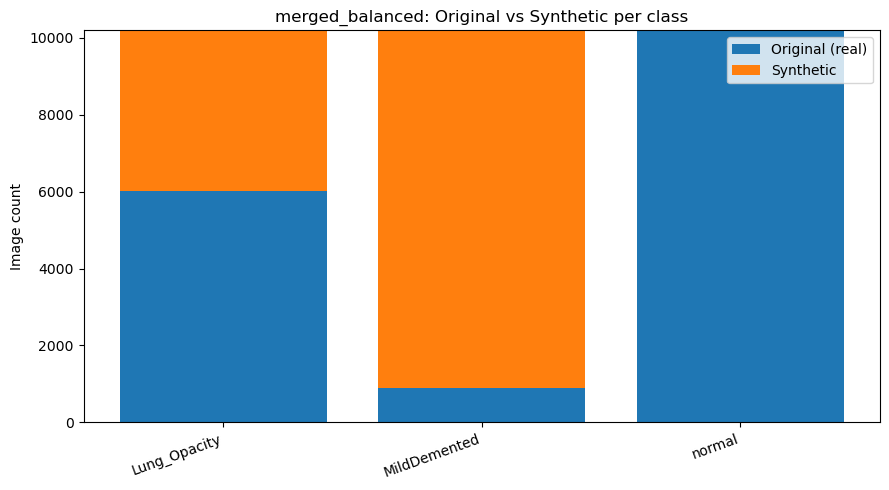

In [11]:
# =======================================
# Plot Original (real) + Synthetic counts from merged_balanced
# =======================================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

MERGED_ROOT = Path(r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\merged_balanced")
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def count_imgs_recursive(d: Path) -> int:
    if not d or not d.exists():
        return 0
    return sum(1 for f in d.rglob("*") if f.is_file() and f.suffix.lower() in IMG_EXTS)

# list base classes = every dir that is NOT *_synthetic
all_dirs = [p for p in MERGED_ROOT.iterdir() if p.is_dir()]
base_classes = sorted([d.name for d in all_dirs if not d.name.lower().endswith("_synthetic")],
                      key=lambda s: s.lower())

# helper: find matching *_synthetic folder case-insensitively
def synthetic_dir_for(base_name: str) -> Path | None:
    target = (base_name + "_synthetic").lower()
    for d in all_dirs:
        if d.is_dir() and d.name.lower() == target:
            return d
    return None

# gather counts
summary = []
for cname in base_classes:
    real_dir  = MERGED_ROOT / cname
    synth_dir = synthetic_dir_for(cname)
    real_n  = count_imgs_recursive(real_dir)
    synth_n = count_imgs_recursive(synth_dir)
    total   = real_n + synth_n
    summary.append((cname, real_n, synth_n, total))

# print summary
print("=== Original (real) + Synthetic in merged_balanced ===")
tot_real = tot_synth = 0
for cname, r, s, t in summary:
    print(f"{cname:<18} real={r:6d}  synthetic={s:6d}  total={t:6d}")
    tot_real  += r
    tot_synth += s
print(f"\nTOTALS -> real={tot_real}  synthetic={tot_synth}  combined={tot_real + tot_synth}")

# plot stacked bars
names = [x[0] for x in summary]
real  = np.array([x[1] for x in summary])
synth = np.array([x[2] for x in summary])

x = np.arange(len(names))
plt.figure(figsize=(9,5))
plt.bar(x, real,  label="Original (real)")
plt.bar(x, synth, bottom=real, label="Synthetic")
plt.xticks(x, names, rotation=20, ha="right")
plt.ylabel("Image count")
plt.title("merged_balanced: Original vs Synthetic per class")
plt.legend()
plt.tight_layout()
plt.show()
